dataset:

---

https://github.com/liaopeiyuan/artbench

list of all augmentations:

https://github.com/fastai/fastai2/blob/master/nbs/09_vision.augment.ipynb

experiments to try:

1. fine tune basic just learning rate (DONE)
2. train only froozen layeres for very long time
 (DONE for 15 epochs, )
3. like fine tune but manual, check for learning rate in between does result improve  (DONE)
4. augmentations default from fastai, train same way as 2., the result doesn't improve (DONE for 15 epochs )
2. train only froozen layeres for very long time with larger architecture
 (DONE for 15 epochs, best so far )

ideas after: weight decay after cetrain time, change how augmentations are done, longer, training, even larger models, dataset reduced artists, random erasing, mixup, label smoothing, tta, traing from scratch,  etc....

# Imports of libraries, creation of an experiment

In [ ]:
# mlflow dependencies
!pip install mlflow pyngrok --quiet

In [2]:
from google.colab import drive
# add flag force_remount=True if you changed or added util files
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# common utils for training functions
# change the path to google drive if elsewhere.
# this copies all of the utils file from drive to separate folder
# if this does not work you can always add functions manualy

import sys
if '/content/utils' not in sys.path:
  sys.path.insert(0, '/content/utils')

!cp -r '/content/drive/My Drive/Colab Notebooks/utils' '/content'

In [6]:
!ls

drive  mlruns  mlruns.db  sample_data  utils


In [5]:
# load mlflow from the google drive
!cp -r  /content/drive/My\ Drive/Colab\ Notebooks/mlflow_data/mlruns  /content/mlruns
!cp  /content/drive/My\ Drive/Colab\ Notebooks/mlflow_data/mlruns.db  /content/mlruns.db

In [ ]:
# copy mlflow back to server
!cp -r /content/mlruns    /content/drive/My\ Drive/Colab\ Notebooks/mlflow_data
!cp   /content/mlruns.db  /content/drive/My\ Drive/Colab\ Notebooks/mlflow_data/mlruns.db

cp: cannot stat './mlruns': No such file or directory
cp: cannot stat 'mlruns.db': No such file or directory


In [ ]:
!ls  ./mlruns/*/

b8d17b3a62ba4f969dae8594895019f8  da50e6ef4b164b57883889fa26942ecb
bc9ca1f9460640d5a8c0d5dfe2c17133


change imports

In [7]:
from fastai.vision.all import *

In [8]:
path = untar_data('https://artbench.eecs.berkeley.edu/files/artbench-10-imagefolder-split.tar')

In [9]:
from artworks_helpers import genres_sorted_era
from fastai_utils import *
from mlflow_utils import *

In [10]:
LOCAL_REGISTRY = "sqlite:///mlruns.db"
EXPERIMENT_NAME = "Artworks Classification"
MLFLOW_PORT = 5000

In [11]:
mlfclient = create_mlflow_client(LOCAL_REGISTRY)

2025/07/13 19:26:09 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/07/13 19:26:09 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


In [12]:
experiment_tags = {
    "dataset": "artbench",
    "link": "https://github.com/liaopeiyuan/artbench",
}

In [13]:
active_experiment_id = get_mlflow_experiment(mlfclient, EXPERIMENT_NAME, experiment_tags=experiment_tags)

In [14]:
active_experiment_id

'1'

# Preparation of dataloaders, model initalization with learning rate finder

In [15]:
SPLIT_SEED = 42
VALID_PERCENTAGE = 0.2
BATCH_SIZE = 64

In [16]:
RESNET18_PRETRAINED = 'resnet18_pretrained'
RESNET34_PRETRAINED = 'resnet34_pretrained'

Experiments without agumentation on paintings

In [17]:
params_training_all_runs = {'data_split': 'random',
    'split_seed': SPLIT_SEED,
    'split_valid_pct': VALID_PERCENTAGE,
    'batch_tfms': 'Normalize.from_stats(*imagenet_stats)',
    'batch_size': BATCH_SIZE,
    'model_name': RESNET18_PRETRAINED,
}

paintings_no_transform = DataBlock(blocks = (ImageBlock, CategoryBlock),
                get_items=get_image_files,
                splitter=RandomSplitter(seed=SPLIT_SEED, valid_pct=VALID_PERCENTAGE),
                batch_tfms=[Normalize.from_stats(*imagenet_stats)],
                get_y=parent_label)

dls = paintings_no_transform.dataloaders(path/"train", bs=BATCH_SIZE)

Experiments with default recommended fastai agmentation on paintings

In [ ]:
params_training_all_runs = {'data_split': 'random',
    'split_seed': SPLIT_SEED,
    'split_valid_pct': VALID_PERCENTAGE,
    'item_tfms': 'Resize(460)',
    'batch_tfms': '[Normalize.from_stats(*imagenet_stats), *aug_transforms(size=224, min_scale=0.75)])',
    'batch_size': BATCH_SIZE,
    'model_name': RESNET18_PRETRAINED,
}

paintings_augmented = DataBlock(blocks = (ImageBlock, CategoryBlock),
                get_items=get_image_files,
                splitter=RandomSplitter(seed=SPLIT_SEED, valid_pct=VALID_PERCENTAGE),
                get_y=parent_label,
                item_tfms=Resize(460),
                batch_tfms=[Normalize.from_stats(*imagenet_stats), *aug_transforms(size=224, min_scale=0.75)])

dls = paintings_augmented.dataloaders(path/"train", bs=BATCH_SIZE)

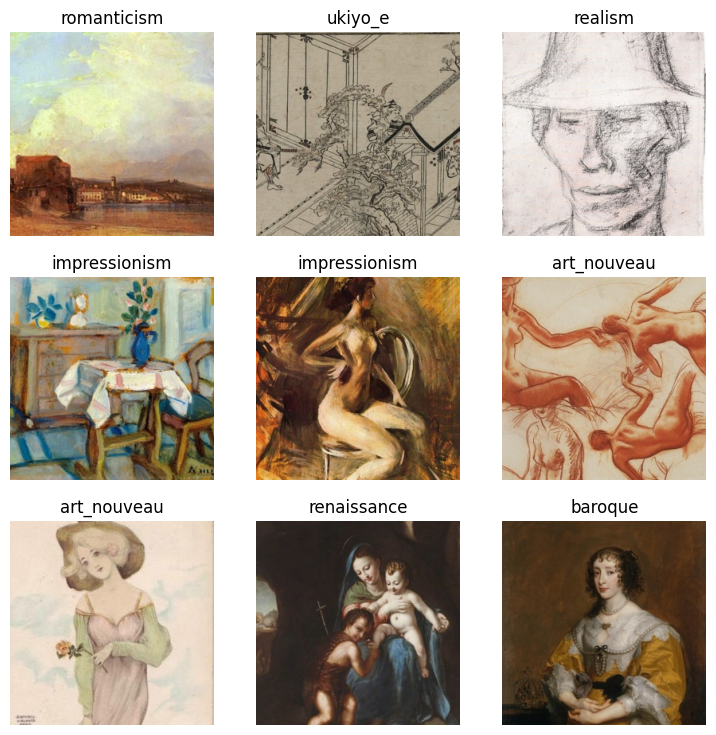

In [18]:
dls.show_batch()

Initial training of learner from scratch


In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 178MB/s]


Bigger model

In [19]:
learn34 = vision_learner(dls, resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 61.8MB/s]


Training of learner from previous snapshot

In [ ]:
# Define the run ID and artifact path of the saved model
run_id = "b8d17b3a62ba4f969dae8594895019f8"
fastai_model_artifact_path = "fastai_model/fastai_resnet18_only_frozen.pkl"


# Download the artifact to a local path
local_path = mlfclient.download_artifacts(run_id, fastai_model_artifact_path)
learn = load_learner(local_path)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
learn.unfreeze()

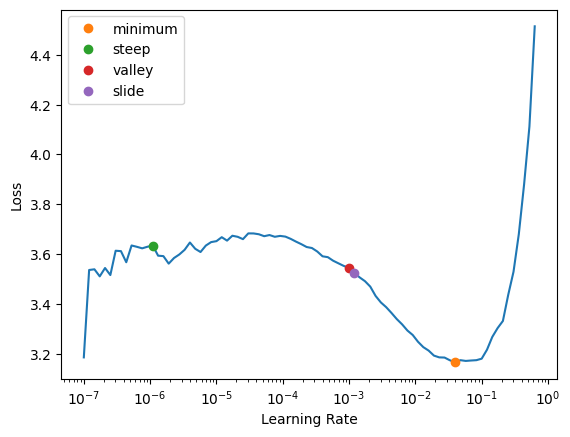

In [ ]:
learn_rate = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

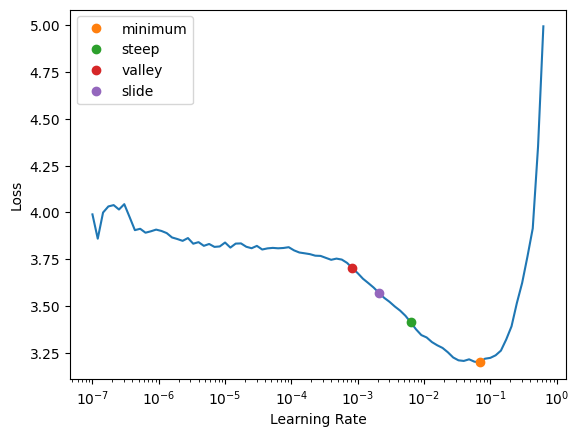

In [20]:
learn_rate = learn34.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [22]:
format_lrs(learn_rate)

metric: valley,  learning_rate:  0.000832
learning rate from the longest valley, 
this could be before the loss starts to increase rapidly

metric: slide,  learning_rate:  0.002089
learning rate following an interval slide rule, 
this could be when loss is decreasing just before the loss starts to increase rapidly

metric: steep,  learning_rate:  0.006310
learning rate when the slope is the steepest, 
loss is decreasing most rapidly

metric: minimum,  learning_rate:  0.006918
1/10th of the minimum point for the loss function, 
largest sensible value to use for learning rate, since minimum is to high



# Various experiments tried

**1.)  Procedure only with fine tune out of the box, simnplest baseline.
Model starts to overfit after epoch 4**

In [ ]:
with mlflow.start_run(experiment_id=active_experiment_id, run_name='artworks_classification_resnet18_fine_tune') as run:


    log_mlflow_params(mlfclient, run, params_training_all_runs)

    run_params = {"learning_rate": 0.001, 'num_epochs': 8}
    log_mlflow_params(mlfclient, run, run_params)

    cb_mlflow = MLFlowTracking(metric_names=['valid_loss', 'train_loss', 'error_rate'], client=mlfclient, run_id=run.info.run_id)

    learn.fine_tune(run_params['num_epochs'], base_lr=run_params['learning_rate'], cbs=[cb_mlflow])

    save_fastai_model_as_artifact(mlfclient, run.info.run_id, learn, 'fastai_resnet18_train_finetune.pkl')

epoch,train_loss,valid_loss,error_rate,time
0,1.633922,1.319624,0.480800,02:09


epoch,train_loss,valid_loss,error_rate,time
0,1.280421,1.138693,0.420000,02:42
1,1.106072,1.065971,0.393000,02:41
2,0.923794,1.026161,0.380000,02:42
3,0.644394,1.105928,0.384000,02:41
4,0.370620,1.290223,0.381900,02:43
5,0.174166,1.461856,0.382600,02:42
6,0.094016,1.539362,0.379800,02:41
7,0.061379,1.559847,0.381400,02:41


artifact_uri saved as model
runs:/da50e6ef4b164b57883889fa26942ecb/fastai_model/fastai_resnet18_finetune.pkl


**2.) Training of the frozen layers, there is no overfitting even when training for multiple epochs, 15 in this case**

In [ ]:
with mlflow.start_run(experiment_id=active_experiment_id, run_name='artworks_classification_resnet18_train_only_frozen') as run:

    log_mlflow_params(mlfclient, run, params_training_all_runs)

    run_params = {"learning_rate": 0.0015, 'num_epochs': 15, 'pct_start': 0.99}
    log_mlflow_params(mlfclient, run, run_params)

    cb_mlflow = MLFlowTracking(metric_names=['valid_loss', 'train_loss', 'error_rate'], client=mlfclient, run_id=run.info.run_id)

    learn.freeze()
    learn.fit_one_cycle(run_params['num_epochs'], lr_max=slice(run_params['learning_rate']), pct_start=run_params['pct_start'], cbs=[cb_mlflow])

    save_fastai_model_as_artifact(mlfclient, run.info.run_id, learn, 'fastai_resnet18_train_only_frozen.pkl')

epoch,train_loss,valid_loss,error_rate,time
0,2.161475,1.554093,0.543700,02:05
1,1.844958,1.398054,0.495900,02:06
2,1.643578,1.306133,0.470000,02:05
3,1.489819,1.252608,0.455600,02:07
4,1.335841,1.214101,0.442400,02:06
5,1.264485,1.184055,0.434500,02:07
6,1.253578,1.167196,0.428100,02:05
7,1.221916,1.148869,0.430700,02:06
8,1.173563,1.138947,0.424700,02:05
9,1.156616,1.118736,0.415800,02:05


artifact_uri saved as model
runs:/b8d17b3a62ba4f969dae8594895019f8/fastai_model/fastai_resnet18_only_frozen.pkl


3.) Inital experiment with training unfrozen model, from previous trained model, the model start to overfit after a while and doesn't improve much on model trained only on last layer

In [ ]:
with mlflow.start_run(experiment_id=active_experiment_id, run_name='artworks_classification_resnet18_unfrozen_training') as run:

    log_mlflow_params(mlfclient, run, params_training_all_runs)

    run_params = {"learning_rate_start":  0.0005 / 100, "learning_rate_end": 0.0005, 'num_epochs': 8, 'pct_start': 0.3, 'div': 5.0}
    log_mlflow_params(mlfclient, run, run_params)

    cb_mlflow = MLFlowTracking(metric_names=['valid_loss', 'train_loss', 'error_rate'], client=mlfclient, run_id=run.info.run_id)

    learn.unfreeze()
    learn.fit_one_cycle(run_params['num_epochs'], lr_max=slice(run_params['learning_rate_start'], run_params['learning_rate_end']),
                        pct_start=run_params['pct_start'], div=run_params['div'], cbs=[cb_mlflow])

    save_fastai_model_as_artifact(mlfclient, run.info.run_id, learn, 'fastai_resnet18_unfrozen_training.pkl')

epoch,train_loss,valid_loss,error_rate,time
0,1.704769,1.310202,0.472400,02:42
1,1.223490,1.125513,0.419500,02:42
2,1.041125,1.047828,0.396000,02:44
3,0.756464,1.072768,0.387000,02:44
4,0.472678,1.208831,0.386100,02:43
5,0.252182,1.406972,0.387400,02:46
6,0.137183,1.520053,0.381700,02:44
7,0.100375,1.527097,0.386900,02:45


artifact_uri saved as model
runs:/bc9ca1f9460640d5a8c0d5dfe2c17133/fastai_model/fastai_resnet18_unfrozen_training.pkl


**4.) Training of the frozen layers(best result until this point), but with default image augmentations added. There is no improvement, results are comparable(slightly worse) and training takes much longer. It would make sense to only select certain subset of augmentations**

In [ ]:
with mlflow.start_run(experiment_id=active_experiment_id, run_name='artworks_classification_resnet18_only_frozen_default_augmentations') as run:

    log_mlflow_params(mlfclient, run, params_training_all_runs)

    run_params = {"learning_rate": 0.0015, 'num_epochs': 15, 'pct_start': 0.99}
    log_mlflow_params(mlfclient, run, run_params)

    cb_mlflow = MLFlowTracking(metric_names=['valid_loss', 'train_loss', 'error_rate'], client=mlfclient, run_id=run.info.run_id)

    learn.freeze()
    learn.fit_one_cycle(run_params['num_epochs'], lr_max=slice(run_params['learning_rate']), pct_start=run_params['pct_start'], cbs=[cb_mlflow])

    save_fastai_model_as_artifact(mlfclient, run.info.run_id, learn, 'fastai_resnet18_train_frozen_default_augmentations.pkl')

epoch,train_loss,valid_loss,error_rate,time
0,2.239172,1.631030,0.573800,06:09
1,1.950193,1.465138,0.525900,05:57
2,1.745160,1.383871,0.499500,06:03
3,1.559374,1.324606,0.487000,05:59
4,1.437881,1.283504,0.473800,06:00
5,1.367539,1.244776,0.457400,05:50
6,1.316685,1.221068,0.453900,05:52
7,1.293423,1.214002,0.455300,05:55
8,1.299828,1.185181,0.442400,06:05
9,1.276677,1.166396,0.435200,06:00


artifact_uri saved as model
runs:/c31e91403a694c52904cc552e44bd120/fastai_model/fastai_resnet18_train_frozen_default_augmentations.pkl


**5.) Training of frozen pretrained model, but with larger architecture, similar result to resnet18, but slightly better result. Training takes 1 minute longer per epoch, but less than when using aug_transformation with resnet18**

In [23]:
params_training_all_runs['model_name'] = RESNET34_PRETRAINED

with mlflow.start_run(experiment_id=active_experiment_id, run_name='artworks_classification_resnet34_train_only_frozen') as run:

    log_mlflow_params(mlfclient, run, params_training_all_runs)

    run_params = {"learning_rate": 0.003, 'num_epochs': 15, 'pct_start':0.99}
    log_mlflow_params(mlfclient, run, run_params)

    cb_mlflow = MLFlowTracking(metric_names=['valid_loss', 'train_loss', 'error_rate'], client=mlfclient, run_id=run.info.run_id)

    learn34.freeze()
    learn34.fit_one_cycle(run_params['num_epochs'], lr_max=slice(run_params['learning_rate']), pct_start=run_params['pct_start'], cbs=[cb_mlflow])

    save_fastai_model_as_artifact(mlfclient, run.info.run_id, learn34, 'fastai_resnet34_train_only_frozen.pkl')

epoch,train_loss,valid_loss,error_rate,time
0,1.998765,1.456292,0.510400,03:04
1,1.664352,1.313532,0.468200,03:05
2,1.453939,1.229843,0.443100,03:05
3,1.336856,1.188163,0.441000,03:04
4,1.267866,1.161655,0.433700,03:06
5,1.206978,1.140290,0.426100,03:04
6,1.169604,1.119724,0.418700,03:05
7,1.163286,1.091787,0.408700,03:05
8,1.134433,1.080800,0.399100,03:04
9,1.117708,1.072214,0.404400,03:05


artifact_uri saved as model
runs:/b974df92c4824a2cbc037c322b884bce/fastai_model/fastai_resnet34_train_only_frozen.pkl


# Saving of the results back


Save the plot figure for the loss

In [24]:
run = get_last_run_id(mlfclient, '1')

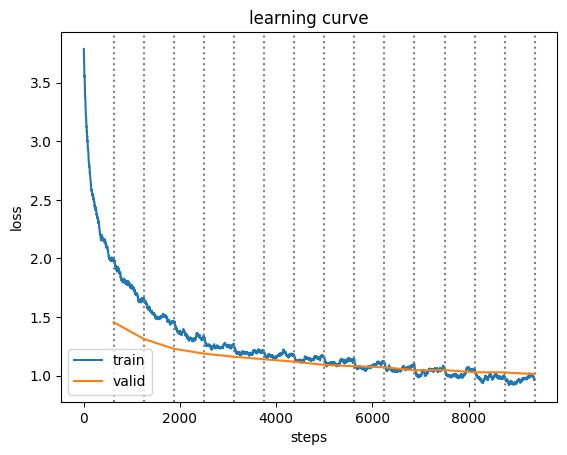

In [26]:
loss_plot_path = "loss_plot.png"
learn.recorder.plot_loss(show_epochs=True).figure.savefig(loss_plot_path)

In [27]:
# Log the plot as an artifact to the  MLflow run
mlfclient.log_artifact(run.info.run_id, local_path=loss_plot_path,
        artifact_path='figures')

Save the classification interpetation

In [28]:
interp = ClassificationInterpretation.from_learner(learn)
add_methods_to_interpetation(interp)

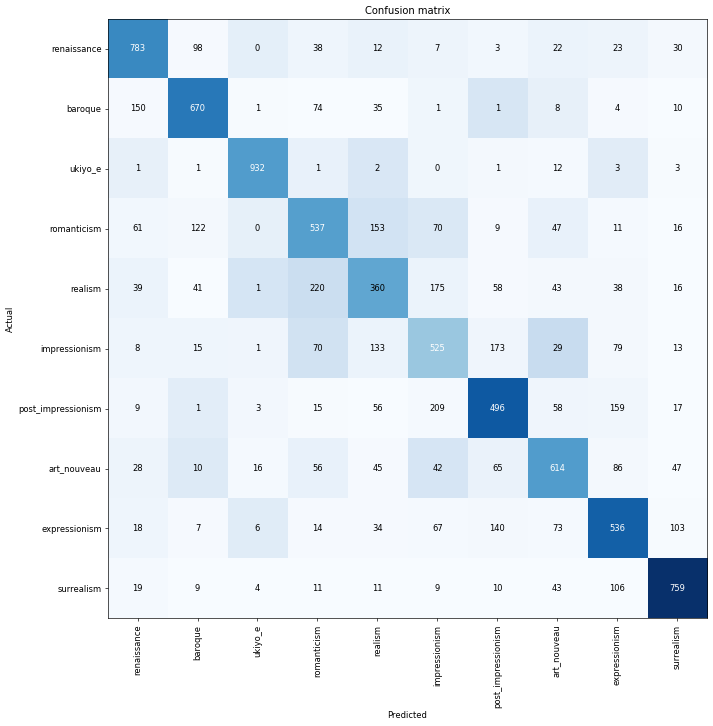

In [29]:
interp.plot_confusion_matrix_vocab(genres_sorted_era, figsize=(12,12), dpi=60).figure.savefig('confussion_matrix')

In [30]:
mlfclient.log_artifact(run.info.run_id, local_path='confussion_matrix.png',
        artifact_path='figures' )

How to save and load the interpretation object

In [31]:
import pickle

# Assuming 'interp' is your fastai Interpretation object
interp_path = "interpretation.pkl"
with open(interp_path, "wb") as f:
    pickle.dump(interp, f)

# Log the interpretation object as an artifact to the current MLflow run
mlfclient.log_artifact(run.info.run_id, local_path=interp_path,
        artifact_path='interpetation' )

If you are using cpu, save back to cpu, to avoid the torch error

In [ ]:
import pickle
import io

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

In [ ]:
artifact_path = "interpetation/interpretation.pkl"

# Download the artifact to a local path
local_path = mlfclient.download_artifacts('da50e6ef4b164b57883889fa26942ecb', artifact_path)

# Load the interpretation object from the local path, mapping to CPU
with open(local_path, "rb") as f:

  contents = CPU_Unpickler(f).load()


**How to display most confused classes**

In [34]:
interp.print_classification_report()

                    precision    recall  f1-score   support

       art_nouveau       0.65      0.61      0.63      1009
           baroque       0.69      0.70      0.70       954
     expressionism       0.51      0.54      0.52       998
     impressionism       0.48      0.50      0.49      1046
post_impressionism       0.52      0.48      0.50      1023
           realism       0.43      0.36      0.39       991
       renaissance       0.70      0.77      0.73      1016
       romanticism       0.52      0.52      0.52      1026
        surrealism       0.75      0.77      0.76       981
           ukiyo_e       0.97      0.97      0.97       956

          accuracy                           0.62     10000
         macro avg       0.62      0.62      0.62     10000
      weighted avg       0.62      0.62      0.62     10000



Checking that the most confused counts follow the genres_era_sorted ordering, closer together means more likely to be confused

In [32]:
def distance(list_of_elems, el1, el2):
  return abs(list_of_elems.index(el1) - list_of_elems.index(el2))


In [33]:
distance_formula = partial(distance, genres_sorted_era)
confused_counts = interp.most_confused()

In [38]:
for count in confused_counts:
    print((count[0], count[1],  distance_formula(count[0], count[1]), count[2]))

('realism', 'romanticism', 1, np.int64(220))
('post_impressionism', 'impressionism', 1, np.int64(209))
('realism', 'impressionism', 1, np.int64(175))
('impressionism', 'post_impressionism', 1, np.int64(173))
('post_impressionism', 'expressionism', 2, np.int64(159))
('romanticism', 'realism', 1, np.int64(153))
('baroque', 'renaissance', 1, np.int64(150))
('expressionism', 'post_impressionism', 2, np.int64(140))
('impressionism', 'realism', 1, np.int64(133))
('romanticism', 'baroque', 2, np.int64(122))
('surrealism', 'expressionism', 1, np.int64(106))
('expressionism', 'surrealism', 1, np.int64(103))
('renaissance', 'baroque', 1, np.int64(98))
('art_nouveau', 'expressionism', 1, np.int64(86))
('impressionism', 'expressionism', 3, np.int64(79))
('baroque', 'romanticism', 2, np.int64(74))
('expressionism', 'art_nouveau', 1, np.int64(73))
('impressionism', 'romanticism', 2, np.int64(70))
('romanticism', 'impressionism', 2, np.int64(70))
('expressionism', 'impressionism', 3, np.int64(67))
('

# Mlfow how to start server to view results in colab


In [36]:
start_mlflow_server_in_collab(LOCAL_REGISTRY, MLFLOW_PORT)

In [ ]:
!ps x | grep '[m]lflow ui'

  40696 ?        Rl     0:01 /usr/bin/python3 /usr/local/bin/mlflow ui --backend-store-uri sqlite:///mlruns.db --port 5000


In [ ]:
 ngrok_access_to_mlflow_in_collab(MLFLOW_PORT)

MLflow Tracking UI: https://17a6ac30f1e7.ngrok-free.app


'https://17a6ac30f1e7.ngrok-free.app'

With MLflow, you can resume a run that has ended. This is a useful feature for continuing training from a checkpoint or adding more information to an existing run.

You can resume a run by using the mlflow.start_run() function with the run_id of the ended run.